## 7. To Do : Mise au point d'un classifieur profond sur les données Mnist (Passer en première lecture)

https://www.kaggle.com/c/digit-recognizer

Vous devez :

- Vous enregistrer sur Kaggle
- Récupérer les données de la compétition digit-recognizer
- Soumettre des prédictions sur les données de test.
- Me fournir par mail d'ici la prochaine séance votre login Kaggle et la performance que vous avez obtenue.

Pour cela vous pourrez suivre, notamment, les pistes évoquées ci-dessous (non exclusives).

Dans tous les cas vous ferez attention à avoir une bonne estimation de la performance en généralisation avant de soumettre un RUN sur Kaggle.
### Piste 1 : Accroître la quantité de données et leur variabilité  

- En bruitant les données (bruit à définir)
- En rajoutant les images miroirs
- En utilisant les pistes décrites ici  http://leon.bottou.org/projects/infimnist
Vous pourrez utiliser [ImageDataGenerator](https://keras.io/preprocessing/image/) de Keras.
### Piste 2 : Exploiter la technique du dropout

En vous inspirant de résultats et d'indications publiés dans
https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf

La couche de Dropout de Keras est définie [ici](https://keras.io/layers/core/).


In [27]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [28]:
# Load the data
train_data = pd.read_csv('digit-recognizer/train.csv')
test_data = pd.read_csv('digit-recognizer/test.csv')

In [29]:
# Split the data into features and labels
X = train_data.drop('label', axis=1).values
y = train_data['label'].values

In [30]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

X_test = test_data.values
X_test_scaled = scaler.transform(X_test)

In [32]:
# Turn our scalar targets into binary categories
num_classes = train_data['label'].nunique()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

In [33]:
print(f'X_train Shape: {X_train_scaled.shape}')
print(f'y_train Data Shape: {y_train.shape}')
print(f'X_val Shape: {X_val_scaled.shape}')
print(f'y_val Data Shape: {y_val.shape}')
print(f'X_test Shape: {X_test_scaled.shape}')

X_train Shape: (33600, 784)
y_train Data Shape: (33600, 10)
X_val Shape: (8400, 784)
y_val Data Shape: (8400, 10)
X_test Shape: (28000, 784)


In [34]:
# Reshape the image data for the convolutional network
X_train_scaled = X_train_scaled.reshape(-1, 28, 28, 1)
X_val_scaled = X_val_scaled.reshape(-1, 28, 28, 1)
X_test_scaled = X_test_scaled.reshape(-1, 28, 28, 1)

In [35]:
print(f'X_train Shape: {X_train_scaled.shape}')
print(f'y_train Data Shape: {y_train.shape}')
print(f'X_val Shape: {X_val_scaled.shape}')
print(f'y_val Data Shape: {y_val.shape}')
print(f'X_test Shape: {X_test_scaled.shape}')

X_train Shape: (33600, 28, 28, 1)
y_train Data Shape: (33600, 10)
X_val Shape: (8400, 28, 28, 1)
y_val Data Shape: (8400, 10)
X_test Shape: (28000, 28, 28, 1)


In [36]:
datagen = ImageDataGenerator(
    rotation_range=10,       
    zoom_range=0.1,          
    width_shift_range=0.1,   
    height_shift_range=0.1,  
    horizontal_flip=False,   
    vertical_flip=False,     
) 

In [37]:
batch_size = 64

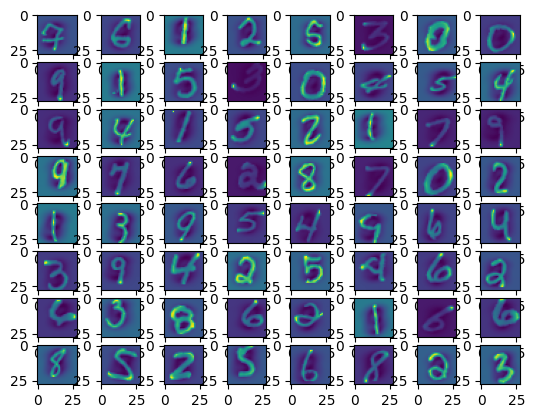

In [38]:
img_iter = datagen.flow(X_train_scaled, y_train, batch_size=batch_size)

x, y = next(img_iter)
fig, ax = plt.subplots(nrows=int(batch_size/8), ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

In [39]:
datagen.fit(X_train_scaled)

In [40]:
# Define the model architecture - VGG like architecture
model = Sequential()
model.add(Conv2D(128, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(64, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(32, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=10, activation="softmax"))

In [41]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
# Train the model
val_data = tf.data.Dataset.from_tensor_slices((X_val_scaled, y_val)).batch(batch_size).repeat()
history = model.fit(img_iter,
          epochs=100,
          steps_per_epoch=len(X_train_scaled)//batch_size,
          validation_steps=len(X_val_scaled)//batch_size,
          validation_data=val_data)

Epoch 1/100
525/525 [==============================] - 12s 21ms/step - loss: 0.3140 - accuracy: 0.9049 - val_loss: 0.3166 - val_accuracy: 0.9079
Epoch 2/100
525/525 [==============================] - 11s 20ms/step - loss: 0.1146 - accuracy: 0.9640 - val_loss: 0.1337 - val_accuracy: 0.9605
Epoch 3/100
525/525 [==============================] - 11s 21ms/step - loss: 0.0853 - accuracy: 0.9734 - val_loss: 0.0752 - val_accuracy: 0.9777
Epoch 4/100
525/525 [==============================] - 11s 21ms/step - loss: 0.0751 - accuracy: 0.9762 - val_loss: 0.0560 - val_accuracy: 0.9832
Epoch 5/100
525/525 [==============================] - 11s 21ms/step - loss: 0.0666 - accuracy: 0.9795 - val_loss: 0.0460 - val_accuracy: 0.9868
Epoch 6/100
525/525 [==============================] - 11s 21ms/step - loss: 0.0589 - accuracy: 0.9820 - val_loss: 0.0512 - val_accuracy: 0.9837
Epoch 7/100
525/525 [==============================] - 11s 21ms/step - loss: 0.0584 - accuracy: 0.9825 - val_loss: 0.0461 - val_ac

In [43]:
# Print the values of the model.history.history dictionary
print(history)

In [44]:
# Extract the values of loss and accuracy
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

In [45]:
print(loss)

[0.3140169680118561, 0.11457649618387222, 0.08528837561607361, 0.0750545784831047, 0.06662412732839584, 0.05889376997947693, 0.05839338153600693, 0.05214357748627663, 0.05094253644347191, 0.04819320887327194, 0.04683176428079605, 0.04483924061059952, 0.04325815290212631, 0.039275284856557846, 0.04083037003874779, 0.038304008543491364, 0.03557265177369118, 0.036762598901987076, 0.034993503242731094, 0.0368058867752552, 0.032566796988248825, 0.031312037259340286, 0.030793795362114906, 0.03098422847688198, 0.03082345426082611, 0.028465013951063156, 0.02719743549823761, 0.027863245457410812, 0.02744857780635357, 0.02598992921411991, 0.024237213656306267, 0.024989044293761253, 0.025951916351914406, 0.02282791957259178, 0.022287338972091675, 0.024270862340927124, 0.024171316996216774, 0.023880518972873688, 0.02188246324658394, 0.02129608578979969, 0.022790132090449333, 0.0192168690264225, 0.02132066898047924, 0.018956895917654037, 0.01917378045618534, 0.021743347868323326, 0.0214858166873455

In [46]:
print(val_loss)

[0.31663885712623596, 0.13365469872951508, 0.07524434477090836, 0.05597690865397453, 0.04600230231881142, 0.051186129450798035, 0.04612378403544426, 0.06780589371919632, 0.04244280606508255, 0.03389004245400429, 0.048781126737594604, 0.03747996315360069, 0.04410867765545845, 0.03520992025732994, 0.03960927948355675, 0.0424790121614933, 0.04455404728651047, 0.031170684844255447, 0.028547530993819237, 0.04453099146485329, 0.028843943029642105, 0.034924570471048355, 0.031861208379268646, 0.04093501344323158, 0.03737480193376541, 0.03544766828417778, 0.05890977755188942, 0.04015268757939339, 0.05000308156013489, 0.05289115756750107, 0.02968265861272812, 0.03328150510787964, 0.035944387316703796, 0.03720366954803467, 0.049110956490039825, 0.04928738996386528, 0.05712687596678734, 0.02288898266851902, 0.03371064364910126, 0.02280612662434578, 0.027813995257019997, 0.0269935242831707, 0.025256996974349022, 0.026111580431461334, 0.0332556813955307, 0.02294980175793171, 0.030275801196694374, 0.

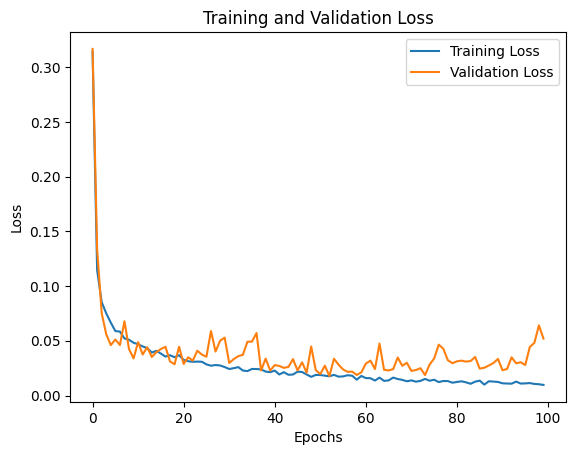

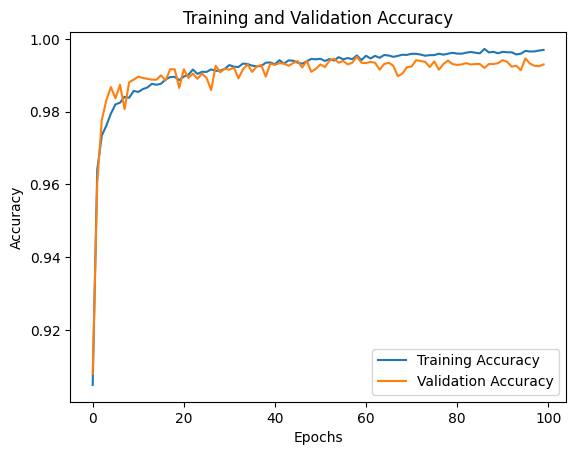

In [47]:
# Plot loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [48]:
predictions = model.predict(X_test_scaled)

875/875 [==============================] - 4s 4ms/step


In [49]:
# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

In [50]:
# Plot a random sample of images with their predicted labels
num_samples = 10
random_indices = np.random.choice(len(X_test), num_samples, replace=False)

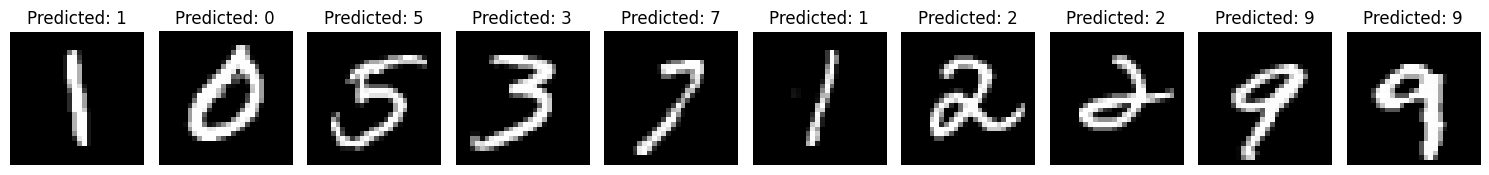

In [51]:
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

for i, idx in enumerate(random_indices):
    image = X_test[idx]
    label = predicted_labels[idx]
    
    axes[i].imshow(image.reshape(28,28), cmap='gray')
    axes[i].set_title(f'Predicted: {label}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()